Epoch 1/20
21/21 [==============================] - 1s 9ms/step - loss: 0.6462 - accuracy: 0.8765 - val_loss: 0.6152 - val_accuracy: 0.9464
Epoch 2/20
21/21 [==============================] - 0s 2ms/step - loss: 0.5837 - accuracy: 0.9524 - val_loss: 0.5486 - val_accuracy: 0.9464
Epoch 3/20
21/21 [==============================] - 0s 2ms/step - loss: 0.5130 - accuracy: 0.9524 - val_loss: 0.4804 - val_accuracy: 0.9464
Epoch 4/20
21/21 [==============================] - 0s 2ms/step - loss: 0.4491 - accuracy: 0.9524 - val_loss: 0.4170 - val_accuracy: 0.9464
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 0.3830 - accuracy: 0.9524 - val_loss: 0.3669 - val_accuracy: 0.9464
Epoch 6/20
21/21 [==============================] - 0s 2ms/step - loss: 0.3366 - accuracy: 0.9524 - val_loss: 0.3308 - val_accuracy: 0.9464
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 0.3021 - accuracy: 0.9524 - val_loss: 0.3086 - val_accuracy: 0.9464
Epoch 8/20
21/21 [==

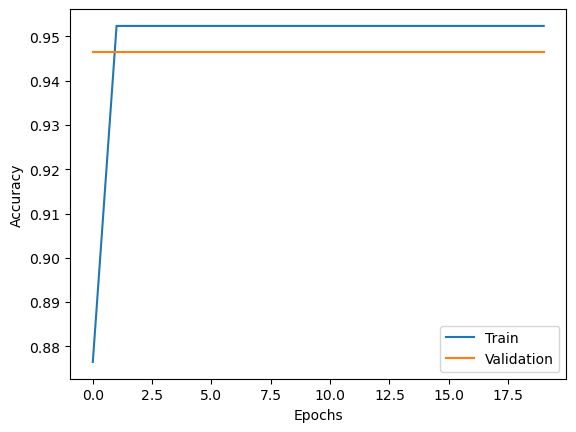

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmp0d445ziz\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmp0d445ziz\assets


TFLite model saved as 'anomaly_detection_model.tflite'.
Sample Input: [0.17723567 0.0998181  0.09948192 0.25186854]
Anomaly Score: 0.0163


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

# Simulate data
gas_data = np.concatenate([np.random.uniform(0, 150, 1000), np.random.uniform(150, 300, 50)])
vibration_x = np.concatenate([np.random.uniform(-5, 5, 1000), np.random.uniform(6, 10, 50)])
vibration_y = np.concatenate([np.random.uniform(-5, 5, 1000), np.random.uniform(6, 10, 50)])
temperature_data = np.concatenate([np.random.uniform(15, 35, 1000), np.random.uniform(50, 70, 50)])
labels = np.concatenate([np.zeros(1000), np.ones(50)])  # 0: Normal, 1: Anomaly

data = pd.DataFrame({"gas": gas_data, "vibration_x": vibration_x, "vibration_y": vibration_y,
                     "temperature": temperature_data, "label": labels}).sample(frac=1).reset_index(drop=True)

# Preprocess data
X = data[["gas", "vibration_x", "vibration_y", "temperature"]]
y = data["label"]
X_scaled = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build and train model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Convert and save model to TensorFlow Lite
model.save("anomaly_detection_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("anomaly_detection_model.tflite", "wb") as f:
    f.write(tflite_model)
print("TFLite model saved as 'anomaly_detection_model.tflite'.")

# Test TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="anomaly_detection_model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

sample_input = np.expand_dims(X_test[0], axis=0).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], sample_input)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
print(f"Sample Input: {X_test[0]}")
print(f"Anomaly Score: {output[0][0]:.4f}")
